In [ ]:
# ! pip install --upgrade numpy pandas tqdm torch catalyst==20.09

     |████████████████████████████████| 14.5MB 227kB/s 
     |████████████████████████████████| 10.5MB 41.6MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
     |████████████████████████████████| 460kB 39.4MB/s 
     |████████████████████████████████| 317kB 41.7MB/s 
     |████████████████████████████████| 163kB 40.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.1

In [1]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

# GPU hack if you need
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import matplotlib.pyplot as plt

# Data

Columns
- `party_rk` – client unique identifier
- `account_rk` – client account unique identifier
- `financial_account_type_cd` – debit/credit card flag
- `transaction_dttm` – operation datetime
- `transaction_type_desc` – purchase/payment/...
- `transaction_amt_rur` – transaction price
- `merchant_type` - DUTY FREE STORES/FUEL DEALERS/RESTAURANTS/ etc
- `merchant_group_rk` - McDonald's/Wildberries/ etc

It's important that table is already sorted by `transaction_dttm` column!!!

In [3]:
DATADIR = "/path/to/dir_with_data" # "./data"

transactions_path = f"{DATADIR}/avk_hackathon_data_transactions.csv"
account_balance_path = f"{DATADIR}/avk_hackathon_data_account_x_balance.csv"
party_products_path = f"{DATADIR}/avk_hackathon_data_party_products.csv"
party_x_socdem_path = f"{DATADIR}/avk_hackathon_data_party_x_socdem.csv"
story_logs_path = f"{DATADIR}/avk_hackathon_data_story_logs.csv"
story_texts_path = f"{DATADIR}/avk_hackathon_data_story_texts.csv"


transaction_example = pd.read_csv(transactions_path, nrows=1000)
account_balance_example = pd.read_csv(account_balance_path)
party_products_example = pd.read_csv(party_products_path)
party_x_socdem_example = pd.read_csv(party_x_socdem_path)
story_logs_example = pd.read_csv(story_logs_path)
story_texts_example = pd.read_csv(story_texts_path)

In [8]:
transaction_example.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


In [9]:
account_balance_example

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0
...,...,...,...,...,...
614429,13734,124222,NaN,NaN,NaN
614430,33502,125615,NaN,NaN,NaN
614431,8735,123871,NaN,NaN,NaN
614432,91302,122557,NaN,NaN,NaN


In [10]:
(account_balance_example["balance_chng"].dropna()>0).sum()

115222

In [11]:
(account_balance_example["balance_chng"].dropna()).shape

(612832,)

In [12]:
party_products_example.head()

,party_rk,product1,product2,product3,product4,product5,product6,product7
0,74874,1,1,0,0,0,0,0
1,83618,0,0,1,1,1,0,0
2,73766,0,0,0,1,1,0,0
3,60218,0,1,0,0,0,0,0
4,47253,0,0,0,1,1,0,0


In [13]:
party_x_socdem_example.head()

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,F,70.0,NaN,0,0
1,66535,F,25.0,NaN,0,0
2,83721,M,55.0,Женат/замужем,0,0
3,88238,F,35.0,NaN,0,0
4,57179,F,30.0,Женат/замужем,0,0


In [14]:
story_logs_example.head()

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


In [16]:
story_texts_example.head()

,story_id,name,story_text
0,794,Профессия: свадебный организатор,"["""",""Как стать свадебным организатором"",""Это Л..."
1,821,Бизнес: магазин электроники,"["""",""Как открыть интернет-магазин электроники""..."
2,824,Как у них: Сингапур,"["""",""Жизнь в Сингапуре"",""Это Славина. Вместе с..."
3,839,Студии йоги,"["""",""Студии йоги"",""7 московских студий, где мо..."
4,848,Как получать больше кэшбэка,"["""",""Как получать больше кэшбэка"",""Подключите ..."


# Transactions -> monthly transactions for each user

In [4]:
transactions_full = pd.read_csv(transactions_path)

In [5]:
transactions_full['transaction_dttm'] = pd.to_datetime(transactions_full['transaction_dttm'])

In [6]:
transactions_full = transactions_full.dropna()

In [7]:
transactions_full.columns

Index(['party_rk', 'account_rk', 'financial_account_type_cd',
       'transaction_dttm', 'transaction_type_desc', 'transaction_amt_rur',
       'merchant_rk', 'merchant_type', 'merchant_group_rk', 'category'],
      dtype='object')

In [8]:
unique_party_rk = transactions_full['party_rk'].unique()

In [9]:
unique_party_rk

array([63404, 57970, 12232, ..., 23519, 65260, 38731])

In [10]:
start = pd.to_datetime('2019-01-01')
rng = pd.date_range(start, periods=12, freq='1M')
print(rng)

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')


### Dataframe where index is one of 12 month and columns - party_rk.
### In cells amount of all transactions in this month for user

In [12]:
users_spendings_per_month = pd.DataFrame(index=rng, columns=np.sort(unique_party_rk))

In [15]:
users_spendings_per_month.head()

,1,5,7,8,9,11,13,14,15,20,...,94594,94595,94598,94600,94602,94603,94606,94607,94608,94610
2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## How user - monthly transactions table was created
It takes about 10 minutes to finish
So below you can load result CSV

In [16]:
# for month_end in users_spendings_per_month.index:
#     month_start = month_end - np.timedelta64(1, 'M')
#     month_mask = ((transactions_full['transaction_dttm'] > month_start) 
#                     & (transactions_full['transaction_dttm'] <= month_end))
#     transactions_in_month = transactions_full[month_mask]
#     for party_rk in tqdm(unique_party_rk):
#         users_spendings_per_month.loc[month_end][party_rk] = transactions_in_month[transactions_in_month['party_rk']==party_rk]['transaction_amt_rur'].sum()

100%|██████████| 49083/49083 [01:00<00:00, 812.66it/s]


In [32]:
users_spendings_per_month = pd.read_csv(f"{DATADIR}/users_spendings_per_month.csv", index_col=0)

## You can see a lot of users have no transactions in months

In [17]:
users_spendings_per_month

,1,5,7,8,9,11,13,14,15,20,...,94594,94595,94598,94600,94602,94603,94606,94607,94608,94610
2019-01-31,0,26596.2,3303.33,3935,0,0,43840.2,0,0,27207,...,0,0,0,0,5568,992.49,5888.7,2026,631.17,0
2019-02-28,10979.4,56151.9,0,5165,0,259,0,0,0,0,...,0,0,2434.42,0,0,931.74,504,0,212,0
2019-03-31,5492,48338.7,1729.76,0,0,1413,31408,0,9482.05,0,...,0,20100,6716,4567.46,7227.29,0,3297.9,5547,0,0
2019-04-30,714.5,106914,0,0,0,5460.09,33256,2208.82,5836.25,0,...,0,23574.1,4036.29,118.99,5122,0,989.8,2930,0,0
2019-05-31,3706.85,0,0,0,4747.39,4972.47,10501.2,44104.2,27769.7,1982,...,37586.9,136,7023,411,8579.13,0,1112.4,0,748.6,0
2019-06-30,14100,4548.63,1727.85,0,2164.5,1894,5281.67,296.7,9041.22,541,...,33077.1,0,868,0,27939.9,0,15842.5,3814,0,0
2019-07-31,9100,12535,0,0,2093.76,2737.82,40111,10859.6,620,0,...,108430,0,1332,0,9084.55,0,2124.4,3675,0,0
2019-08-31,0,13645,0,0,111.9,0,0,15304.6,2697.17,1878.92,...,0,0,16052.3,0,0,0,749.51,2715,0,0
2019-09-30,0,0,339143,2106,226.7,4599,0,13545.5,0,0,...,0,0,0,0,0,0,4874.26,4908,0,0
2019-10-31,0,70781.5,289573,466,1202.02,0,0,10524.8,484,1847,...,0,0,0,0,0,0,0,3863,0,8519.01


## Here we save users that are active
#### active user - user that have **at least 10 000 roubles per each month** of transactions

In [18]:
cleaned_users_spendings_per_month = users_spendings_per_month.dropna()
active_users_mask = (cleaned_users_spendings_per_month.values<10000)
active_users_mask = (np.sum(active_users_mask, axis=0)==0)
active_users_mask = cleaned_users_spendings_per_month.columns[active_users_mask]

In [19]:
cleaned_users_spendings_per_month[active_users_mask]

,71,87,143,144,185,209,238,263,345,420,...,84365,89271,89910,92320,93039,93053,93098,93158,93401,94294
2019-01-31,31324.8,77374.6,14656.3,14947.3,151556,16573.1,13344.2,28614,11801,30598,...,22626,15316.9,102206,50065.8,23742.8,16487,18946.8,70345,153391,92200
2019-02-28,33380.1,14686.1,14644.9,14292.6,165346,14853.5,25669.8,53972.6,37505.7,21551.4,...,25003.7,27543.3,417619,49254.7,19532.7,15431.3,186727,81298.1,123328,98515
2019-03-31,108484,30250.2,55339.6,26718.1,70405,15864.4,22115.4,47028.7,27502.7,29625.2,...,83278,15425.8,215724,35480.7,32019,22575.3,354400,47934.3,151854,140474
2019-04-30,89374.7,135523,19819.7,16243.3,233986,18845.5,17250.6,83140.3,11261.9,116183,...,54465,17316.3,41375.7,140879,24223.9,21999.4,174775,16687.7,134599,281212
2019-05-31,40856.1,191088,10452.6,20804.8,71790,15332,20198.3,30762,16764.8,28223.9,...,40449,15583.6,19543,42391.4,37256.5,19452,31076.8,67096.8,37289.2,391091
2019-06-30,26432.1,125667,12666,20964.9,77923.5,15880.8,17395.5,104249,15622.6,21180.1,...,39752,10833.1,42295.1,43952.1,44597.3,24470.1,110857,31851.7,131380,536740
2019-07-31,55986.6,118298,22450.5,18425.2,236391,14623,27437.3,54195.8,92553.4,14613.4,...,61484.4,19076.9,34637.1,17296.8,16631.6,18050.2,122746,98425.8,80367,440219
2019-08-31,54048.7,12192.8,27482.5,18439.3,122277,17570.8,25112.4,69037.4,33746.8,21430.4,...,103716,19714.7,358435,13751.4,22054.8,30766.5,88763.1,81827.2,63647.9,333323
2019-09-30,142095,54196.7,87192.3,16057.8,268020,14691,32815,39927.8,110305,28232.1,...,81752,11826.9,19038,30371.1,23652.7,19244.2,157091,74986.8,24280,35052
2019-10-31,140660,106319,144245,19827.6,267586,15445.4,13705,42200,30536,25796,...,90088.7,16550.2,427241,52312.8,21927.9,11201.3,77482.1,47709,19639.6,10067


### As you can see only 4.6% of all users of dataset are active users
And we have only ~2k users for whom we can make usefull predictions.
It's hard (if not impossible) to make usefull predictions for the person with 3 active months.

**Total unique users in the dataset**

In [22]:
transactions_full['party_rk'].unique().shape

(49083,)

In [20]:
%matplotlib inline 

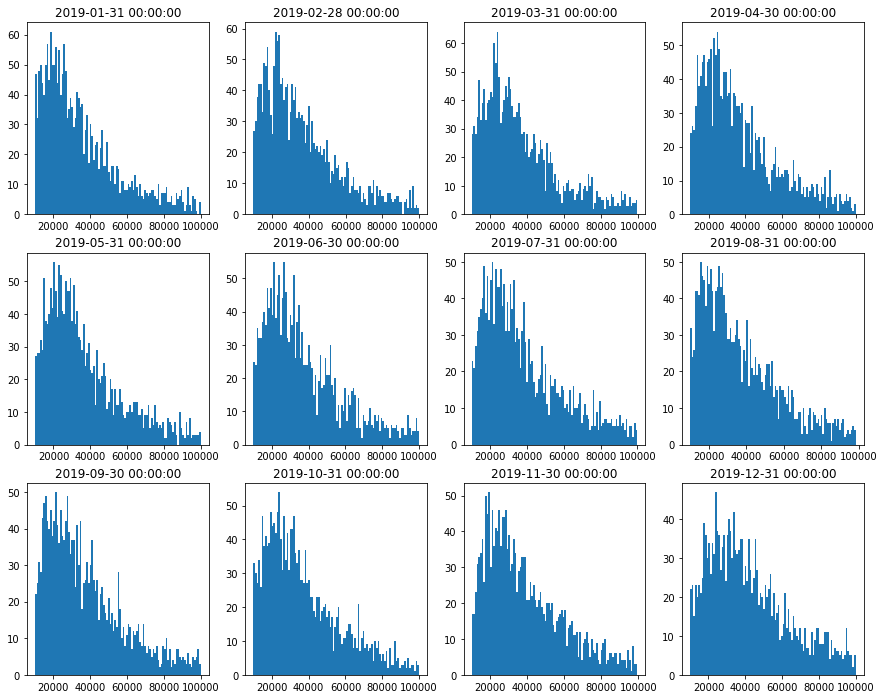

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
for i, ax in enumerate(axes.flatten()):
    month_end = users_spendings_per_month.index[i]
    month_hist = cleaned_users_spendings_per_month[active_users_mask].loc[month_end].dropna()
    month_hist = month_hist[(month_hist < 1e5)] 
    month_hist = month_hist[(month_hist != 0)] 
#     ax.set_xscale("log")
#     ax.set_xlim(0, 1e5)
    ax.set_title(month_end)
    ax.hist(month_hist.values, bins=100)
#     ax.set_xlabel("Roubles per month")
#     sns.distplot(month_hist.values,
#                          ax=ax, bins=100)